# French Wikipedia Newcomer Welcoming Experiment Power Analysis
[J. Nathan Matias](https://github.com/natematias)
May/June 2019

Some components of this are drawn from [github.com/natematias/poweranalysis-onlinebehavior](https://github.com/natematias/poweranalysis-onlinebehavior).

Eventually, this power analysis code will ask a series of questions of [historical data prepared by Max Klein](https://docs.google.com/document/d/1zj-yIR7s7-MWEk3u9O1kQTfL0d6bF0Yz1H_CV-n1T4U/edit?usp=drive_web&ouid=117701977297551627494) and produce a series of answers used for power analysis and study design in CivilServant's research with Wikipedians on [the effects of welcoming new Wikipedians](https://meta.wikimedia.org/wiki/CivilServant%27s_Wikimedia_studies/Testing_French_Wikipedia%27s_welcome_message)
* The experiment plan is on Overleaf: (TBD) **Experiment Plan: Welcoming Newcomers on Wikipedia

This analysis will define and report the following:

* Assumptions about minimum observable treatment effects for each DV
* Reports on the statistical power, bias, and type S error rate for all possible estimators, given the above assumptions
* Data-driven decisions:
    * Decisions about the final set of measures to use
    * Decisions about the randomization procedure
    * Decisions about the final estimators to use
    * Decisions about the sample size to specify for the experiment
    * Decisions about any stop rules to use in the experiment

# Load Libraries

In [1]:
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS)
library(ggplot2)
library(rlang)
library(gmodels)
library(tidyverse)
library(viridis)
library(fabricatr)
library(estimatr)
library(DeclareDesign)
library(blockTools)
library(beepr)
## Installed DeclareDesign 0.13 using the following command:
# install.packages("DeclareDesign", dependencies = TRUE,
#                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))

library(survminer)
library(survival)
## ^^ documentation: https://cran.r-project.org/web/packages/survminer/vignettes/Informative_Survival_Plots.html

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.2.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()        masks rlang::%||%()
✖ purrr::%@%()         masks rlang::%@%()
✖ purrr::as_function() masks rlang::as_function()
✖ dplyr::filter()      masks stats::filter()
✖ purrr::flatten()     masks rlang::flatten()
✖ purrr::flatten_chr() masks rlang::flatten_chr()
✖ purrr::flatten_dbl() masks rlang::flatten_dbl()
✖ purrr::flatten_int() masks rlang::flatten_int()
✖ purrr::flatten_lgl() masks rlang::flatten_lgl()
✖ purrr::inv

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] survival_2.43-3      survminer_0.4.3      ggpubr_0.2          
 [4] magrittr_1.5         beepr_1.3            blockTools_0.6-3    
 [7] DeclareDesign_0.12.0 randomizr_0.16.1     estimatr_0.14       
[10] fabricatr_0.6.0      viridis_0.5.1        viridisLite_0.3.0   
[13] forcats_0.3.0        str

# Load Power Analysis Dataframes and Review the Data

In [2]:
data.path <- "~/Tresors/CivilServant/projects/wikipedia-integration/fr-newcomer-study/datasets/"
fr.power.df <- read.csv(file.path(data.path, "french_power-analysis_dataset_sim_date_20180307_v1.csv"))
fr.power.df$user_registration <- as.Date(fr.power.df$user_registration)
fr.power.df$lang <- "fr"
simulated.treatment.date <- as.Date("20180306", "%Y%M%D")

In [3]:
colnames(fr.power.df)

[1] "user_id"                                          
  [2] "user_name"                                        
  [3] "has_email"                                        
  [4] "has_gender"                                       
  [5] "user_registration"                                
  [6] "labour_hours_90_post_treatment"                   
  [7] "num_edits_90_post_treatment"                      
  [8] "num_edits_week_1_post_treatment"                  
  [9] "num_edits_week_2_post_treatment"                  
 [10] "num_edits_week_3_post_treatment"                  
 [11] "num_edits_week_4_post_treatment"                  
 [12] "num_edits_week_5_post_treatment"                  
 [13] "num_edits_week_6_post_treatment"                  
 [14] "num_edits_week_7_post_treatment"                  
 [15] "num_edits_week_8_post_treatment"                  
 [16] "num_edits_week_9_post_treatment"                  
 [17] "num_edits_week_10_post_treatment"                 
 [18] "num_edits_week_11_post_treatment"                 
 [19] "num_edits_week_12_post_treatment"                 
 [20] "any_edits_week_1_post_treatment"                  
 [21] "any_edits_week_2_post_treatment"                  
 [22] "any_edits_week_3_post_treatment"                  
 [23] "any_edits_week_4_post_treatment"                  
 [24] "any_edits_week_5_post_treatment"                  
 [25] "any_edits_week_6_post_treatment"                  
 [26] "any_edits_week_7_post_treatment"                  
 [27] "any_edits_week_8_post_treatment"                  
 [28] "any_edits_week_9_post_treatment"                  
 [29] "any_edits_week_10_post_treatment"                 
 [30] "any_edits_week_11_post_treatment"                 
 [31] "any_edits_week_12_post_treatment"                 
 [32] "labor_hours_week_1_post_treatment"                
 [33] "labor_hours_week_2_post_treatment"                
 [34] "labor_hours_week_3_post_treatment"                
 [35] "labor_hours_week_4_post_treatment"                
 [36] "labor_hours_week_5_post_treatment"                
 [37] "labor_hours_week_6_post_treatment"                
 [38] "labor_hours_week_7_post_treatment"                
 [39] "labor_hours_week_8_post_treatment"                
 [40] "labor_hours_week_9_post_treatment"                
 [41] "labor_hours_week_10_post_treatment"               
 [42] "labor_hours_week_11_post_treatment"               
 [43] "labor_hours_week_12_post_treatment"               
 [44] "any_labour_hours_week_1_post_treatment"           
 [45] "any_labour_hours_week_2_post_treatment"           
 [46] "any_labour_hours_week_3_post_treatment"           
 [47] "any_labour_hours_week_4_post_treatment"           
 [48] "any_labour_hours_week_5_post_treatment"           
 [49] "any_labour_hours_week_6_post_treatment"           
 [50] "any_labour_hours_week_7_post_treatment"           
 [51] "any_labour_hours_week_8_post_treatment"           
 [52] "any_labour_hours_week_9_post_treatment"           
 [53] "any_labour_hours_week_10_post_treatment"          
 [54] "any_labour_hours_week_11_post_treatment"          
 [55] "any_labour_hours_week_12_post_treatment"          
 [56] "num_edits_nonmain_week_1_post_treatment"          
 [57] "num_edits_nonmain_week_2_post_treatment"          
 [58] "num_edits_nonmain_week_3_post_treatment"          
 [59] "num_edits_nonmain_week_4_post_treatment"          
 [60] "num_edits_nonmain_week_5_post_treatment"          
 [61] "num_edits_nonmain_week_6_post_treatment"          
 [62] "num_edits_nonmain_week_7_post_treatment"          
 [63] "num_edits_nonmain_week_8_post_treatment"          
 [64] "num_edits_nonmain_week_9_post_treatment"          
 [65] "num_edits_nonmain_week_10_post_treatment"         
 [66] "num_edits_nonmain_week_11_post_treatment"         
 [67] "num_edits_nonmain_week_12_post_treatment"         
 [68] "any_edits_nonmain_week_1_post_treatment"          
 [69] "any_edits_nonmain_week_2_post_treatment"          


# Summarize Data

In [4]:
day.range <- as.integer(max(fr.power.df$user_registration) - min(fr.power.df$user_registration))
num.accounts <- nrow(fr.power.df)

print(paste("Out of", nrow(fr.power.df), "newcomer accounts"))
print(paste("At a rate of", as.integer(num.accounts / day.range), "per day"))
print(paste(sprintf("%0.1f", 
            nrow(subset(fr.power.df, has_email=="True")) / 
            nrow(fr.power.df) * 100), "% have email addresses", sep=""))
cat("\n")
print(paste(sprintf("%0.1f", 
            nrow(subset(fr.power.df, day_1_activation_namespace_0_post_treatment=="True")) / 
            nrow(fr.power.df) * 100), "% made a namespace '0' edit after 1 day", sep=""))
print(paste(sprintf("%0.1f", 
            nrow(subset(fr.power.df, day_2_activation_namespace_0_post_treatment=="True")) / 
            nrow(fr.power.df) * 100), "% made a namespace '0' edit after 2 days", sep=""))
print(paste(sprintf("%0.1f", 
            nrow(subset(fr.power.df, day_7_activation_namespace_0_post_treatment=="True")) / 
            nrow(fr.power.df) * 100), "% made a namespace '0' edit after 7 days", sep=""))
cat("\n")
print(paste(sprintf("%0.1f", 
            nrow(subset(fr.power.df, day_1_activation_namespace_non_0_post_treatment=="True")) / 
            nrow(fr.power.df) * 100), "% made a non-0 namespace edit after 1 day", sep=""))
print(paste(sprintf("%0.1f", 
            nrow(subset(fr.power.df, day_2_activation_namespace_non_0_post_treatment=="True")) / 
            nrow(fr.power.df) * 100), "% made a non-0 namespace edit after 2 days", sep=""))
print(paste(sprintf("%0.1f", 
            nrow(subset(fr.power.df, day_7_activation_namespace_non_0_post_treatment=="True")) / 
            nrow(fr.power.df) * 100), "% made a non-0 namespace edit after 7 days", sep=""))
cat("\n")
print(paste(sprintf("%0.1f", 
            nrow(subset(fr.power.df, response_rate_nouveaux_allposts_post_treatment>0)) / 
            nrow(fr.power.df) * 100), "% posted to the forum nouveaux within 7 days after registration", sep=""))
print(paste(sprintf("%0.1f", 
            nrow(subset(fr.power.df, response_rate_nouveaux_newquestion_post_treatment>0)) / 
            nrow(fr.power.df) * 100), "% posted a new question to the forum nouveaux within 7 days after registration", sep=""))

cat("\n")
print(paste(sprintf("%0.1f", 
            nrow(subset(fr.power.df, response_rate_personalization_7_post_treatment=="True")) / 
            nrow(fr.power.df) * 100), "% contacted the inviting editor within 7 days after registration", sep=""))

cat("\n")
print(paste(sprintf("%0.1f", 
            nrow(subset(fr.power.df, response_rate_draft_7_post_treatment=="True")) / 
            nrow(fr.power.df) * 100), "% created a draft article within 7 days after registration", sep=""))

[1] "Out of 82355 newcomer accounts"
[1] "At a rate of 925 per day"
[1] "99.8% have email addresses"

[1] "17.5% made a namespace '0' edit after 1 day"
[1] "17.7% made a namespace '0' edit after 2 days"
[1] "18.3% made a namespace '0' edit after 7 days"

[1] "6.4% made a non-0 namespace edit after 1 day"
[1] "6.7% made a non-0 namespace edit after 2 days"
[1] "7.3% made a non-0 namespace edit after 7 days"

[1] "0.3% posted to the forum nouveaux within 7 days after registration"
[1] "0.3% posted a new question to the forum nouveaux within 7 days after registration"

[1] "0.3% contacted the inviting editor within 7 days after registration"

[1] "1.6% created a draft article within 7 days after registration"


In [5]:
## CREATE 0 / 1 variables out of the above variables 
fr.power.df$bin_day_1_activation_namespace_0_post_treatment <- as.integer(fr.power.df$day_1_activation_namespace_0_post_treatment == "True")
fr.power.df$bin_day_2_activation_namespace_0_post_treatment <- as.integer(fr.power.df$day_2_activation_namespace_0_post_treatment == "True")
fr.power.df$bin_day_7_activation_namespace_0_post_treatment <- as.integer(fr.power.df$day_7_activation_namespace_0_post_treatment == "True")
fr.power.df$bin_day_1_activation_namespace_non_0_post_treatment <- as.integer(fr.power.df$day_1_activation_namespace_non_0_post_treatment == "True")
fr.power.df$bin_day_2_activation_namespace_non_0_post_treatment <- as.integer(fr.power.df$day_2_activation_namespace_non_0_post_treatment == "True")
fr.power.df$bin_day_7_activation_namespace_non_0_post_treatment <- as.integer(fr.power.df$day_7_activation_namespace_non_0_post_treatment == "True")
fr.power.df$bin_response_rate_nouveaux_allposts_post_treatment <- as.integer(fr.power.df$response_rate_nouveaux_allposts_post_treatment > 0 )
fr.power.df$bin_response_rate_nouveaux_newquestion_post_treatment <- as.integer(fr.power.df$response_rate_nouveaux_newquestion_post_treatment > 0 )
fr.power.df$bin_response_rate_personalization_7_post_treatment <- as.integer(fr.power.df$response_rate_personalization_7_post_treatment == "True")
fr.power.df$bin_response_rate_draft_7_post_treatment <- as.integer(fr.power.df$response_rate_draft_7_post_treatment == "True")

In [6]:
fr.power.df$bin_day_7_any_action <- 
    (fr.power.df$bin_day_7_activation_namespace_0_post_treatment + 
    fr.power.df$bin_day_7_activation_namespace_non_0_post_treatment +
    fr.power.df$bin_response_rate_personalization_7_post_treatment +
    fr.power.df$bin_response_rate_draft_7_post_treatment) > 0

In [7]:
summary(fr.power.df$has_gender)

female    male not_set 
     97     234   82024

### Summarize Labor Hours over 90 Days

[1] "Labor Hours 90 Days After Treatment"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0     0.6     0.0   504.6 

[1] "log1p Labor Hours 90 Days After Treatment"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   0.000   0.242   0.000   6.226 

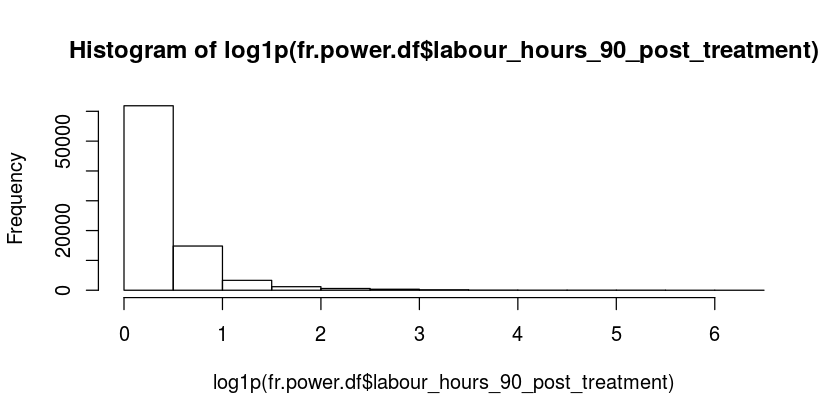

In [8]:
print("Labor Hours 90 Days After Treatment")
summary(fr.power.df$labour_hours_90_post_treatment)
hist(log1p(fr.power.df$labour_hours_90_post_treatment))

print("log1p Labor Hours 90 Days After Treatment")
summary(log1p(fr.power.df$labour_hours_90_post_treatment))

In [9]:
labor.hour.90.dist <- fitdistr(as.integer(fr.power.df$labour_hours_90_post_treatment), densfun="negative binomial")

Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm

In [10]:
labor.hour.90.dist

     size        mu   
  0.179003   0.616364 
 (0.001863) (0.005767)

# Configure Power Analysis

In [11]:
source.path <- "~/CivilServant-Wikipedia-Analysis/power-analysis"
source(file.path(source.path, "general-power-analysis-utils.R"))

In [12]:
current.treat.any.action.7.day.rate <- nrow(subset(fr.power.df, bin_day_7_any_action > 0 )) / nrow(fr.power.df)
current.treat.any.action.7.day.rate

[1] 0.235

In [52]:
## overall scenario:
## current treatment is slightly better than control
## alt treatment is slightly better than current treatment

pa.config <- data.frame(
    pa.label = "fr.experiment",
    n.max = 100000,
    n.min = 30000,
    
    ## ANY ACTION AFTER 7 DAYS
    ## since we are working from the treatment condition
    ## we imagine the control and other treatments from this point
    aa7.ctl           <- current.treat.any.action.7.day.rate - 0.01,
    aa7.current.treat <- current.treat.any.action.7.day.rate,
    aa7.new.treat     <- current.treat.any.action.7.day.rate + 0.01,
    
    ## LABOR HOURS
    lh.current.treat.mu = labor.hour.90.dist$estimate[['mu']],
    lh.current.treat.theta = labor.hour.90.dist$estimate[['size']],
    lh.ctl.effect.irr = exp(-0.1053), # 0.9 incidence rate ratio
    lh.new.treat.effect.irr = exp(0.0953) # 1.1 incidence rate ratio
)

In [60]:
diagnose.experiment  <- function( n.size, cdf, sims.count = 500, bootstrap.sims.count = 500){
    design <-   declare_population(N = n.size) +
            declare_potential_outcomes(
                
                ## ANY ACTION AFTER 7 DAYS
                AA7_Z_0 = rbinom(n=n.size, 1, cdf$aa7.ctl),
                AA7_Z_1 = rbinom(n=n.size, 1, cdf$aa7.current.treat),
                AA7_Z_2 = rbinom(n=n.size, 1, cdf$aa7.new.treat),
                
                # LABOR HOURS AFTER 90 DAYS
                LH90_Z_0 = rnegbin(n=N, mu =  cdf$lh.current.treat.mu + mu.diff.from.mu.irr(
                                                cdf$lh.current.treat.mu,
                                                cdf$lh.ctl.effect.irr),
                                 theta = cdf$lh.current.treat.theta),
                LH90_Z_1 = rnegbin(n=N, mu = cdf$lh.current.treat.mu, 
                                 theta = cdf$lh.current.treat.theta),
                LH90_Z_2 = rnegbin(n=N, mu =  cdf$lh.current.treat.mu + mu.diff.from.mu.irr(
                                                cdf$lh.current.treat.mu,
                                                cdf$lh.new.treat.effect.irr),
                                 theta = cdf$lh.current.treat.theta)
                ) +
    declare_assignment(num_arms = 3,
                       conditions = (c("0", "1", "2"))) +
    ## we compare 0 to 1 in this simulation because 1 is the baseline
    declare_estimand(ate_LH90_0_1 = log(cdf$lh.ctl.effect.irr)) +
    declare_estimand(ate_LH90_2_1 = log(cdf$lh.new.treat.effect.irr)) +
    declare_estimand(ate_AA7_1_0_dm  = aa7.current.treat - aa7.ctl) +
    declare_estimand(ate_AA7_2_0_dm  = aa7.new.treat     - aa7.ctl) +
    declare_estimand(ate_AA7_2_1_dm  = aa7.new.treat     - aa7.current.treat) +
    declare_reveal(outcome_variables=c("LH90", "AA7")) +
    declare_estimator(estimand = "ate_LH90_0_1", label="NB LH90 0_1", handler = tidy_estimator(function(data){
        data$Z <- factor(data$Z, levels = c("1", "0", "2"))
        m <- glm.nb(formula = LH90 ~ Z, data)
        out <- subset(tidy(m), term == "Z0")
        transform(out,
            conf.low = estimate - 1.96*std.error,
            conf.high = estimate + 1.96*std.error
        )
    })) +
    declare_estimator(estimand = "ate_LH90_2_1", label="NB LH90 2_1", handler = tidy_estimator(function(data){
        data$Z <- factor(data$Z, levels = c("1", "0", "2"))
        m <- glm.nb(formula = LH90 ~ Z, data)
        out <- subset(tidy(m), term == "Z2")
        transform(out,
            conf.low = estimate - 1.96*std.error,
            conf.high = estimate + 1.96*std.error
        )})) +                  
    declare_estimator(AA7 ~ Z, condition1="0", condition2="1", estimand = "ate_AA7_1_0_dm", label="DM AA7 1_0") +
    declare_estimator(AA7 ~ Z, condition1="0", condition2="2", estimand = "ate_AA7_2_0_dm", label="DM AA7 2_0") +
    declare_estimator(AA7 ~ Z, condition1="1", condition2="2", estimand = "ate_AA7_2_1_dm", label="DM AA7 2_1") 
#    declare_estimator(estimand = "ate_AA7_2_1_dm", label="DM AA7 2_1", handler = tidy_estimator(function(data){
#        data$Z <- factor(data$Z, levels = c("1", "0", "2"))
#        m <- difference_in_means(formula = AA7 ~ Z, data)
#        out <- subset(tidy(m), term == "Z0")        
#    }))
    
    diagnosis <- diagnose_design(design, sims = sims.count, 
                                 bootstrap_sims = bootstrap.sims.count)
    diagnosis
}

# Conduct Power Analysis (Iterative)

In [62]:
#diagnose.experiment(100,pa.config, sims.count = 100)

In [63]:
interval = 5000
power.iterate.df <- iterate.for.power(pa.config, 
                                      diagnosis.method=diagnose.experiment, 
                                      iteration.interval = interval)

[1] "min: 30000 max: 100000 current: 30000"
[1] "     seconds: 408"
[1] "min: 30000 max: 100000 current: 35000"
[1] "     seconds: 473"
[1] "min: 30000 max: 100000 current: 40000"
[1] "     seconds: 542"
[1] "min: 30000 max: 100000 current: 45000"
[1] "     seconds: 608"
[1] "min: 30000 max: 100000 current: 50000"
[1] "     seconds: 675"
[1] "min: 30000 max: 100000 current: 55000"
[1] "     seconds: 744"
[1] "min: 30000 max: 100000 current: 60000"
[1] "     seconds: 814"
[1] "min: 30000 max: 100000 current: 65000"
[1] "     seconds: 878"
[1] "min: 30000 max: 100000 current: 70000"
[1] "     seconds: 933"
[1] "min: 30000 max: 100000 current: 75000"
[1] "     seconds: 994"
[1] "min: 30000 max: 100000 current: 80000"
[1] "     seconds: 1057"
[1] "min: 30000 max: 100000 current: 85000"
[1] "     seconds: 1119"
[1] "min: 30000 max: 100000 current: 90000"
[1] "     seconds: 1184"
[1] "min: 30000 max: 100000 current: 95000"
[1] "     seconds: 1249"
[1] "min: 30000 max: 100000 current: 100000"

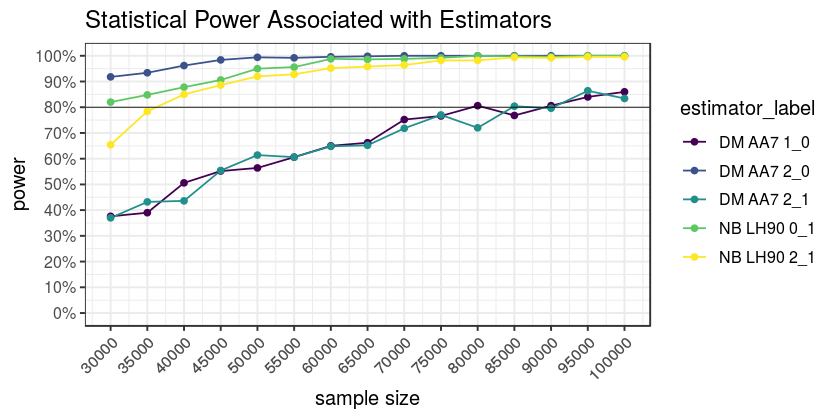

In [65]:
ggplot(power.iterate.df, aes(n, power, color=estimator_label)) +
    ## CHART SUBSTANCE
    geom_line() +
    geom_point() +
    ## LABELS AND COSMETICS
    geom_hline(yintercept=0.8, size=0.25) +
    theme_bw(base_size = 12, base_family = "Helvetica") +
    theme(axis.text.x = element_text(angle=45, hjust = 1)) +
    scale_y_continuous(breaks = seq(0,1,0.1), limits = c(0,1), labels=scales::percent) +
    scale_x_continuous(breaks = seq(pa.config$n.min,pa.config$n.max,interval)) +
    scale_color_viridis(discrete=TRUE) +
    xlab("sample size") +
    ggtitle("Statistical Power Associated with Estimators")

In [78]:
diagnose.two.arm.experiment  <- function( n.size, cdf, sims.count = 500, bootstrap.sims.count = 500){
    design <-   declare_population(N = n.size) +
            declare_potential_outcomes(
                
                ## ANY ACTION AFTER 7 DAYS
                AA7_Z_0 = rbinom(n=n.size, 1, cdf$aa7.ctl),
                AA7_Z_1 = rbinom(n=n.size, 1, cdf$aa7.current.treat),
                
                # LABOR HOURS AFTER 90 DAYS
                LH90_Z_0 = rnegbin(n=N, mu =  cdf$lh.current.treat.mu + mu.diff.from.mu.irr(
                                                cdf$lh.current.treat.mu,
                                                cdf$lh.ctl.effect.irr),
                                 theta = cdf$lh.current.treat.theta),
                LH90_Z_1 = rnegbin(n=N, mu = cdf$lh.current.treat.mu, 
                                 theta = cdf$lh.current.treat.theta)
                ) +
    declare_assignment(num_arms = 2,
                       conditions = (c("0", "1"))) +
    ## we compare 0 to 1 in this simulation because 1 is the baseline
    declare_estimand(ate_LH90_0_1 = log(cdf$lh.ctl.effect.irr)) +
#    declare_estimand(ate_LH90_2_1 = log(cdf$lh.new.treat.effect.irr)) +
    declare_estimand(ate_AA7_1_0_dm  = aa7.current.treat - aa7.ctl) +
#    declare_estimand(ate_AA7_2_0_dm  = aa7.new.treat     - aa7.ctl) +
#    declare_estimand(ate_AA7_2_1_dm  = aa7.new.treat     - aa7.current.treat) +
    declare_reveal(outcome_variables=c("LH90", "AA7")) +
    declare_estimator(estimand = "ate_LH90_0_1", label="NB LH90 0_1", handler = tidy_estimator(function(data){
        data$Z <- factor(data$Z, levels = c("1", "0"))
        m <- glm.nb(formula = LH90 ~ Z, data)
        out <- subset(tidy(m), term == "Z0")
        transform(out,
            conf.low = estimate - 1.96*std.error,
            conf.high = estimate + 1.96*std.error
        )
    })) +
#     declare_estimator(estimand = "ate_LH90_2_1", label="NB LH90 2_1", handler = tidy_estimator(function(data){
#         data$Z <- factor(data$Z, levels = c("1", "0", "2"))
#         m <- glm.nb(formula = LH90 ~ Z, data)
#         out <- subset(tidy(m), term == "Z2")
#         transform(out,
#             conf.low = estimate - 1.96*std.error,
#             conf.high = estimate + 1.96*std.error
#         )})) +                  
    declare_estimator(AA7 ~ Z, condition1="0", condition2="1", estimand = "ate_AA7_1_0_dm", label="DM AA7 1_0")
#     declare_estimator(AA7 ~ Z, condition1="0", condition2="2", estimand = "ate_AA7_2_0_dm", label="DM AA7 2_0") +
#     declare_estimator(AA7 ~ Z, condition1="1", condition2="2", estimand = "ate_AA7_2_1_dm", label="DM AA7 2_1") 
#    declare_estimator(estimand = "ate_AA7_2_1_dm", label="DM AA7 2_1", handler = tidy_estimator(function(data){
#        data$Z <- factor(data$Z, levels = c("1", "0", "2"))
#        m <- difference_in_means(formula = AA7 ~ Z, data)
#        out <- subset(tidy(m), term == "Z0")        
#    }))
    
    diagnosis <- diagnose_design(design, sims = sims.count, 
                                 bootstrap_sims = bootstrap.sims.count)
    diagnosis
}

In [ ]:
interval = 5000
two.arm.power.iterate.df <- iterate.for.power(pa.config, 
                                      diagnosis.method=diagnose.two.arm.experiment, 
                                      iteration.interval = interval)

[1] "min: 30000 max: 100000 current: 30000"
[1] "     seconds: 200"
[1] "min: 30000 max: 100000 current: 35000"
[1] "     seconds: 231"
[1] "min: 30000 max: 100000 current: 40000"
[1] "     seconds: 263"
[1] "min: 30000 max: 100000 current: 45000"
[1] "     seconds: 295"
[1] "min: 30000 max: 100000 current: 50000"
[1] "     seconds: 328"
[1] "min: 30000 max: 100000 current: 55000"
[1] "     seconds: 362"
[1] "min: 30000 max: 100000 current: 60000"
[1] "     seconds: 395"
[1] "min: 30000 max: 100000 current: 65000"
[1] "     seconds: 427"
[1] "min: 30000 max: 100000 current: 70000"
[1] "     seconds: 458"
[1] "min: 30000 max: 100000 current: 75000"
